In [186]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import matplotlib.colors as mcolors

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import requests
from io import BytesIO

In [187]:
# Data Reading

# df = pd.read_excel("../data/Registro Público de Emissões.xlsx")

URL = "https://raw.githubusercontent.com/thiagoneye/project-ccus_analysis/main/data/Registro%20P%C3%BAblico%20de%20Emiss%C3%B5es.xlsx"
response = requests.get(URL)
df = pd.read_excel(BytesIO(response.content), engine="openpyxl")

# Data Processing

df = df[df["Escopo"] == "Total"]
df.drop(columns=["Setor da Indústria", "Escopo"], inplace=True)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:].reset_index()
df = df.rename(columns={"index": "Years"})

# Company Names

dict_company_names = {
    "ArcelorMittal": "S-1",
    "Votorantim": "C-2",
    "Ternium": "S-2",
    "Suzano": "P-1",
    "CBA": "A-1",
    "Intercement": "C-1",
}

list_of_companies = list(dict_company_names.values())
list_of_companies.sort()
df = df.rename(columns=dict_company_names)

# Dataframe Cleaning

for col in list_of_companies:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(float)

# Convert a unit of measurement

df.iloc[:, 1:] = df.iloc[:, 1:] / 1e6

# Domain Ranges

past_range = [2008, 2017]
commom_range = [2017, 2023]
gap_range = [2024, 2025]
future_range = [2026, 2031]

# Show Dataframe Informations

display(df.head())
display(df.info())

Empresa,Years,P-1,CSN,C-1,S-2,C-2,S-1,A-1,ISA Energia
0,2008,1.071559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,0.734910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1.050929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1.369238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,1.355714,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Years        16 non-null     int64  
 1   P-1          16 non-null     float64
 2   CSN          11 non-null     object 
 3   C-1          11 non-null     float64
 4   S-2          11 non-null     float64
 5   C-2          9 non-null      float64
 6   S-1          7 non-null      float64
 7   A-1          7 non-null      float64
 8   ISA Energia  7 non-null      object 
dtypes: float64(6), int64(1), object(2)
memory usage: 1.3+ KB


None

In [ ]:
# Auxiliaries Function


def applies_power_law(X, y, X_pred):
    X_last = X[-1]
    y_last = y[-1]
    y_pred = y_last * np.exp(np.log(0.91) * (X_pred - X_last) / (2030 - X_last))
    return y_pred


def applies_constant_line(y, X_pred):
    y_last = y[-1]
    y_pred = y_last * np.ones(len(X_pred))
    return y_pred


def get_values_from_dataframe(df, company_name):
    X = df.Years.values
    y = df.loc[:, company_name].values
    X = X[~np.isnan(y)]
    y = y[~np.isnan(y)]
    return X, y


def get_values(df, company_name, commom_range, gap_range, future_range):
    """
    Return:
        X_hist: Historical X values
        y_hist: Historical y values
        X_filt: X values for the common domain
        y_filt: Y values for the common domain
        X_gap: X values for the gap period (2024 and 2025)
        y_gap: Y values for the gap period (2024 and 2025)
        X_train: X_hist and X_gap concatenated
        y_train: y_hist and y_gap concatenated
        X_pred: Future X values
        X_plot: Future X values (starting in 2025)
    """
    X_hist, y_hist = get_values_from_dataframe(df, company_name)

    df_filt = df[df.Years >= commom_range[0]]
    X_filt, y_filt = get_values_from_dataframe(df_filt, company_name)

    X_gap = np.array(gap_range)
    X_gap = np.insert(X_gap, 0, X_hist[-1])
    y_gap = y_hist[-1] * np.ones(len(X_gap))

    X_train = np.concatenate((X_hist, X_gap))
    y_train = np.concatenate((y_hist, y_gap))

    X_pred = np.array(range(future_range[0], 2031))

    X_plot = np.insert(X_pred, 0, X_gap[-1])

    return (
        X_hist,
        y_hist,
        X_filt,
        y_filt,
        X_gap,
        y_gap,
        X_train,
        y_train,
        X_pred,
        X_plot,
    )


def set_weight_dict(function: str, weights):
    return {"function": function, "weights": weights}


def set_weights_sigmoid(data, common_range_delimiter=5, k=0.05):
    """Applies a sigmoid as weighting function for the weighted SVR."""

    t0 = common_range_delimiter
    weights = 1 / (1 + np.exp(-k * (data - t0)))

    return weights


def generate_weight_pairs_matrix(weight_a, weight_b, n):
    """Generate matrix with weight lists [wa, wb], such that wa + wb = 1 for tests."""

    # Matrix Columns
    col2 = np.linspace(weight_a, weight_b, n)
    col1 = 1 - col2

    # Matrix
    weight_pairs = np.column_stack((col1, col2))

    return weight_pairs


def fit_model(
    X,
    y,
    model: str,
    weighting_params: dict,
    commom_range_delimiter,
    C=10,
    epsilon=0.0001
):
    """Select models for weighted regression.

    weighting_params: dict with keys
      - "function": "jump" | "sigmoid"
      - "weights":
              if "function" == "jump", must be a list of two floats: e.g. [0.1, 0.9],
                                       which will determine two constant weights
                                       for the past and common windows.
              if "function" == "sigmoid", must be a single float: e.g. k=0.01,
                                       which will control the sigmoid curve steep.

      For any model, the time t=t_b is the cutoff year that closes the past window
      and opens the common window, thus implying that this is the point where the
      weighting function should transition.
    """

    # Weighting
    if not all(key in weighting_params for key in ["function", "weights"]):
        raise ValueError("weighting_params must have keys 'function' and 'weights'.")

    if weighting_params["function"] == "jump":
        weights = set_weights_jump(
            y, weighting_params["weights"], commom_range_delimiter
        )

    elif weighting_params["function"] == "sigmoid":
        weights = set_weights_sigmoid(
            y, commom_range_delimiter, weighting_params["weights"]
        )

    else:
        raise ValueError("Invalid weighting function. Must be 'jump' or 'sigmoid'.")

    # Reshape Input for 2D
    X = X.reshape(-1, 1)

    if model == "poly":
        M = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        M.fit(X, y, linearregression__sample_weight=weights)

    elif model == "svr-rbf":
        M = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=10, epsilon=0.0001))
        M = SVR(kernel="rbf")
        M.fit(X, y, sample_weight=weights)

    elif model == "svr-poly":
        M = SVR(kernel="poly")
        M.fit(X, y, sample_weight=weights)

    elif model == "rf":
        M = RandomForestRegressor(n_estimators=100)
        M.fit(X, y, sample_weight=weights)

    return M


def add_axvspan_annotation(ax, ta, tb, y_baseline=None):
    """
    Adds an axvspan and an annotation with text based on tb.

    Parameters:
    ax: Matplotlib axis object.
    ta: Start of axvspan.
    tb: End of axvspan.
    y_baseline: Height of the annotation baseline (optional, defaults to the middle of the y-axis).

    Returns:
    None (adds axvspan and annotation to the axis).
    """

    if ta < 2017:
        text = "past"
        ax.axvspan(ta, tb, alpha=0.3, color="#e9ecef")
    elif ta == 2017:
        text = "common"
        ax.axvspan(ta, tb, alpha=0.3, color="#ebdef0")
    elif ta == 2023:
        text = "gap"
        ax.axvspan(ta, tb, alpha=0.3, color="#e7f5ff")
    else:
        text = "future"
        ax.axvspan(ta, tb, alpha=0.3, color="#ebfbee")

    x_center = (ta + tb) / 2

    if y_baseline is None:
        y_min, y_max = ax.get_ylim()
        y_baseline = (y_min + y_max) / 2

    ax.annotate(
        text,
        xy=(x_center, y_baseline),
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round", facecolor="white", edgecolor="lightgray", alpha=0.8
        ),
    )


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)

In [ ]:
# Grid Search

results = []

for company_id, company_name in enumerate(list_of_companies):
    # Data Processing for Training
    data = get_values(df, company_name, commom_range, gap_range, future_range)
    _, _, _, _, _, _, X_train, y_train, _, _ = data

    commom_range_delimiter = np.where(X_train == commom_range[0])[0][0]

    best_score = np.inf  # negative if R2 or positive in other cases
    best_weight = None
    best_model = None

    for k in [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]:
        weighting_params = set_weight_dict("sigmoid", k)
        weights = set_weights_sigmoid(
            y_train, commom_range_delimiter, weighting_params["weights"]
        )

        # Create pipeline with scaler and SVR
        pipeline = make_pipeline(
            StandardScaler(), SVR(kernel="rbf")  # or linear, poly, etc.
        )

        # Define o grid de parâmetros a testar
        param_grid = {
            "svr__C": [0.001, 0.01, 0.1, 1, 10, 100],  # Low C = more regularization
            "svr__epsilon": [
                0.0001,
                0.001,
                0.01,
                0.1,
                1,
                10,
                100,
            ],  # error tolerance range
        }

        # Create the GridSearchCV
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,  # 5-fold cross-validation
            scoring="neg_mean_absolute_error",  # or 'r2', 'neg_mean_absolute_error' 'neg_mean_squared_error' etc.
            n_jobs=-1,  # uses all CPU cores
        )

        # Executa o grid search
        grid_search.fit(X_train.reshape(-1, 1), y_train, svr__sample_weight=weights)

        mae = -grid_search.best_score_

        # Check if this was the best score
        if mae < best_score: # > if R2 or < in other cases
            best_score = grid_search.best_score_
            best_weight = k
            best_c = grid_search.best_params_["svr__C"]
            best_e = grid_search.best_params_["svr__epsilon"]

    # Results
    results.append(
        [
            company_name,
            best_weight,
            best_c,
            best_e,
            best_score,
        ]
    )


best_param_by_company = dict()
best_param_by_company = {item[0]: item[1:] for item in results}

results = pd.DataFrame(
    results, columns=["company", "k", "svr_C", "svr_epsilon", "best_score"]
)

display(results)


/tmp/ipykernel_88720/105613202.py:77: RuntimeWarning: overflow encountered in exp
  weights = 1 / (1 + np.exp(-k * (data - t0)))


,company,k,svr_C,svr_epsilon,best_score
0,A-1,0.01,10.000,0.0001,-0.306151
1,C-1,0.01,0.001,0.0001,-0.142354
2,C-2,0.01,0.001,0.0001,-0.959598
3,P-1,0.01,10.000,0.0001,-0.660900
4,S-1,0.01,10.000,0.0001,-3.166465
5,S-2,0.01,10.000,0.0010,-0.453198


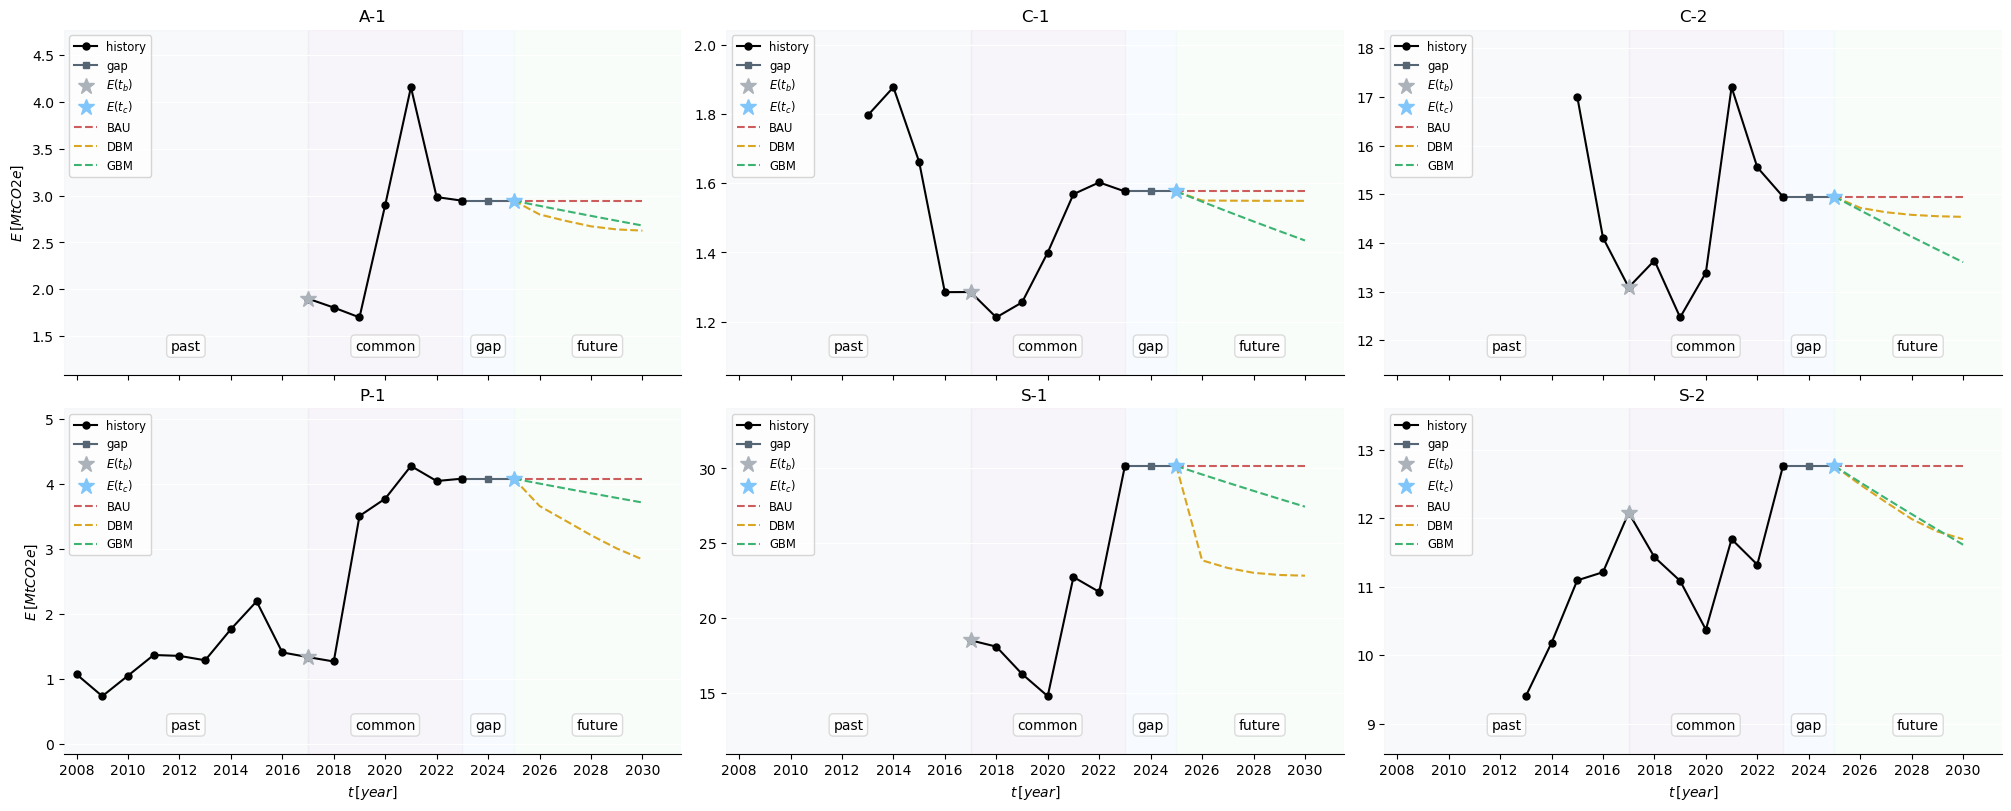

In [192]:
# Execution

# Training Parameters (SVR)

k = 0.01
weighting_params = set_weight_dict("sigmoid", k)

# Plots

colors = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
}

# Start Plot

fig, axs = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True, sharex=True)
axs = axs.flatten()

for company_id, company_name in enumerate(list_of_companies):
    # Data Processing for Training
    data = get_values(df, company_name, commom_range, gap_range, future_range)
    X_hist, y_hist, X_filt, y_filt, X_gap, y_gap, X_train, y_train, X_pred, X_plot = (
        data
    )

    commom_range_delimiter = np.where(X_train == commom_range[0])[0][0]

    # Preparing Variable for Data Export
    output = dict()
    output["Years"] = X_pred.tolist()

    # Plot (Past, Commom, and No Informed)
    ax = axs[company_id]
    ax.plot(X_hist, y_hist, "-ok", ms=5, label="history", zorder=10)
    ax.plot(X_gap, y_gap, "-s", color="#566573", ms=4, label="gap")
    ax.plot(
        X_filt[0], y_filt[0], "*", color="#abb2b9", ms=12, label="$E(t_b)$", zorder=11
    )
    ax.plot(
        X_train[-1],
        y_train[-1],
        "*",
        color="#80c6fa",
        ms=12,
        label="$E(t_c)$",
        zorder=12,
    )

    # BAU
    y_pred = applies_constant_line(y_train, X_pred)
    y_plot = np.insert(y_pred, 0, y_gap[-1])
    output[f"{company_name} - BAU"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=colors["BAU"], label="BAU")

    # DBM
    y_pred = fit_model(
        X_train,
        y_train,
        "svr-rbf",
        weighting_params,
        commom_range_delimiter,
        C=best_param_by_company[company_name][1],
        epsilon=best_param_by_company[company_name][2],
    ).predict(X_pred.reshape(-1, 1))
    y_plot = np.insert(y_pred, 0, y_gap[-1])
    output[f"{company_name} - DBM"] = y_pred.tolist()

    ax.plot(X_plot, y_plot, "--", color=colors["DBM"], label="DBM")

    # GBM
    y_pred = applies_power_law(X_train, y_train, X_pred)
    y_plot = np.insert(y_pred, 0, y_gap[-1])

    ax.plot(X_plot, y_plot, "--", color=colors["GBM"], label="GBM")

    # Configure Plot
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.set_xlim([past_range[0] - 0.5, future_range[1] + 0.5])

    y_min, y_max = min(y_train), max(y_train)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    y_baseline = np.mean([y_min, y_min_lim])
    ax.set_ylim([y_min_lim, y_max_lim])

    add_axvspan_annotation(
        ax, past_range[0] - 0.5, past_range[1], y_baseline=y_baseline
    )
    add_axvspan_annotation(ax, commom_range[0], commom_range[1], y_baseline=y_baseline)
    add_axvspan_annotation(ax, commom_range[1], gap_range[1], y_baseline=y_baseline)
    add_axvspan_annotation(
        ax, gap_range[1], future_range[1] + 0.5, y_baseline=y_baseline
    )

    ax.grid(color="w", axis="y")
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc="upper left", fontsize="small")
    ax.set_title(f"{company_name}")

    if company_id in [0, 3]:
        ax.set_ylabel("$E \\, [MtCO2e]$")

    if company_id >= 3:
        ax.set_xlabel("$t \\, [year]$")

fig.savefig(f"../img/Forecast.png", dpi=600, bbox_inches="tight")

In [ ]:
# Export Values

output = pd.DataFrame(output)
# output.to_csv("../data/Forecast (MtCO2e).csv")
# output.to_excel("../data/Forecast (MtCO2e).xlsx")